In [21]:
%pylab inline
import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score
import tensorflow as tf
import keras

Populating the interactive namespace from numpy and matplotlib


/Users/ozgecanyuzer/opt/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [22]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, BatchNormalization, Dropout #When added to a model, max pooling reduces the dimensionality of images by reducing the number of pixels in the output from the previous convolutional layer.
from tensorflow.keras.models import Sequential  #Why this model  #The output is dependent of the previous input                                                    #MaxPool2D, Flatten,Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from shutil import copyfile
from sklearn.metrics import accuracy_score, classification_report

In [25]:
import os
import csv
import numpy as np
import pandas as pd
import os
import imageio
import glob
import pathlib
path = '/Users/ozgecanyuzer/Documents/Classes/Ling_412/Preprocessing/Cropped Images/train/train_4'

with open('train_4_final.csv', 'w', newline='') as csvfile:
    files = []
    for r, d, f in os.walk(path):
        for _file in f:
            if '.jpg' in _file:
                files.append(_file)

    header = ["image_id", "label"]
    # Create a writer from csv module
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(i for i in header)

    for f in files:  # find type of file
        t = f[0:-4]

        if "100" in t:
            t = 1
        elif "200" in t:
            t = 2
        elif "300" in t:
            t = 3
        elif "400" in t:
            t = 4
        elif "500" in t:
            t = 5
        elif "600" in t:
            t = 6

        writer.writerow([f, t]) 

In [26]:
train = pd.read_csv('/Users/ozgecanyuzer/Documents/Classes/Ling_412/Coding/train_4_final.csv')
print(train)

             image_id  label
0     100_2349228.jpg      1
1     100_2350779.jpg      1
2     100_2348136.jpg      1
3     100_2347563.jpg      1
4     100_2351301.jpg      1
...               ...    ...
6454  100_2349231.jpg      1
6455  100_2346102.jpg      1
6456  100_2352177.jpg      1
6457  300_2406574.jpg      3
6458  100_2353269.jpg      1

[6459 rows x 2 columns]


In [27]:
from PIL import Image
import cv2
IMG_DIR = '//Users/ozgecanyuzer/Documents/Classes/Ling_412/Preprocessing/Cropped Images/train/train_4'
temp = []
for img in os.listdir(IMG_DIR):
        img_array = cv2.imread(os.path.join(IMG_DIR,img), cv2.IMREAD_GRAYSCALE)
        if img_array is not None:
            img_array = (img_array.flatten())
            img_array = img_array.astype(float)
            temp.append(img_array)

print(temp)
train_x = np.stack(temp)

[array([ 70.,  74.,  81., ..., 115., 115., 115.]), array([ 70.,  72.,  73., ..., 112., 111., 110.]), array([114., 117., 105., ..., 108., 108., 108.]), array([ 72.,  76.,  81., ..., 114., 114., 114.]), array([ 71.,  78.,  88., ..., 107., 107., 107.]), array([87., 90., 92., ..., 82., 81., 80.]), array([ 71.,  75.,  81., ..., 113., 113., 113.]), array([97., 97., 97., ..., 83., 83., 83.]), array([94., 95., 96., ..., 95., 95., 95.]), array([ 99., 100., 101., ...,  95.,  95.,  95.]), array([70., 70., 70., ..., 97., 97., 97.]), array([91., 93., 94., ..., 82., 82., 82.]), array([95., 95., 95., ..., 89., 89., 89.]), array([101., 101., 102., ...,  91.,  91.,  91.]), array([91., 92., 94., ..., 88., 88., 88.]), array([67., 66., 65., ..., 87., 87., 87.]), array([ 70.,  71.,  72., ..., 109., 108., 108.]), array([90., 90., 90., ..., 83., 82., 82.]), array([97., 97., 97., ..., 85., 85., 85.]), array([67., 67., 67., ..., 97., 97., 97.]), array([66., 68., 73., ..., 97., 97., 97.]), array([106., 106., 10

In [28]:
train_y = keras.utils.np_utils.to_categorical(train.label.values)

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.20,random_state=4) 

In [30]:
len(x_train)

5167

In [31]:
len(x_test)

1292

In [32]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)

In [33]:
x_train = x_train / 255 #Normalizing the images
x_test = x_test / 255

In [34]:
train_x_temp = x_train.reshape(-1, 180, 110, 1)
test_x_temp = x_test.reshape(-1, 180, 110, 1)
print(shape(test_x_temp))

(1292, 180, 110, 1)


In [57]:
early_stopping = EarlyStopping( monitor = 'val_accuracy', min_delta=0.001, # minimium amount of change to count as an improvement
                                patience=3, # how many epochs to wait before stopping
                                restore_best_weights=True
                              ) 
strategy = tf.distribute.MirroredStrategy() #Distrubitues the training across multiple GPU's

with strategy.scope():
    model = Sequential([ Conv2D(128 , (3,3)  , padding = 'same' , activation = 'relu' , input_shape = (180,110,1)),
                         MaxPool2D(2,2), 
                         Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
                         Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
                         MaxPool2D(2,2),
                         Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
                         MaxPool2D(2,2),
                        #Flatten reduces the dimensions of the layer. Literally flattens it. Why we use it : A flatten operation on a tensor reshapes the tensor to have the shape that is equal to the number of elements contained in tensor non including the batch dimension.
                         Flatten(),#Dense creates a fully-connected hidden layer with  512 nodes or 24 nodes like the one below
                         Dense(units = 1024, activation="relu"),
                         Dropout(0.2),
                         Dense(units = 256 , activation = 'relu'),#Dense is my neural network it's a hyperparameter
                         Dropout(0.2),#The dropout rate is set to 20%, meaning one in 5 inputs will be randomly excluded from each update cycle.
                         Dense(units = 7 , activation = 'softmax')
                       ]) #The model first learns 128 filters, then 64, 64 and finally 7 filters. The padding is same, meaning the output volume size matches the input volume size.
                       #use_bias isn't used.
    
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy']) #Loss is the most important
                        
model.summary() #Try putting in more layers

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 180, 110, 128)     1280      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 90, 55, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 90, 55, 64)        73792     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 90, 55, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 45, 27, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 45, 27, 25)        14425     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 13, 25)       

In [58]:
trained_model = model.fit(train_x_temp, y_train, epochs=5, validation_data=(test_x_temp, y_test), callbacks = [early_stopping])

Train on 5167 samples, validate on 1292 samples
Epoch 1/5
5167/5167 [==============================] - 875s 169ms/sample - loss: 1.5035 - accuracy: 0.4157 - val_loss: 1.2432 - val_accuracy: 0.4884
Epoch 2/5
5167/5167 [==============================] - 863s 167ms/sample - loss: 1.2064 - accuracy: 0.5061 - val_loss: 1.0181 - val_accuracy: 0.5913
Epoch 3/5
5167/5167 [==============================] - 863s 167ms/sample - loss: 0.7929 - accuracy: 0.7027 - val_loss: 0.4711 - val_accuracy: 0.8251
Epoch 4/5
5167/5167 [==============================] - 862s 167ms/sample - loss: 0.3295 - accuracy: 0.8858 - val_loss: 0.1359 - val_accuracy: 0.9605
Epoch 5/5
5167/5167 [==============================] - 865s 167ms/sample - loss: 0.1385 - accuracy: 0.9572 - val_loss: 0.0793 - val_accuracy: 0.9776


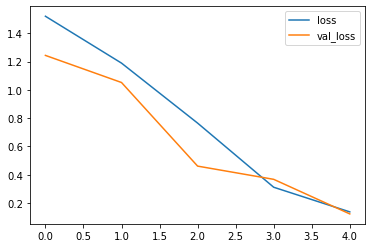

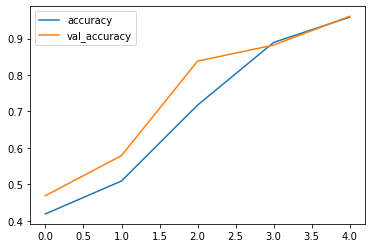

In [52]:
history_df = pd.DataFrame(trained_model.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [13]:
model.save("sign_language_understanding_less_data.h5")

In [53]:
model.evaluate(test_x_temp, y_test)

1292/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.12312480212180607, 0.9613003]

In [54]:
y_pred = np.argmax(model.predict(test_x_temp),axis = 1) 
y_true = np.argmax(y_test, axis =1)

In [55]:
print('Model Accuracy = ', (accuracy_score(y_true, y_pred)*100),"%")

Model Accuracy =  96.13003095975232 %


In [48]:
print(classification_report(y_true, y_pred))#two layers, third

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       536
           2       0.98      1.00      0.99       195
           3       0.98      0.99      0.99       211
           4       1.00      0.97      0.99       112
           5       0.99      0.97      0.98        80
           6       0.99      0.97      0.98       158

    accuracy                           0.99      1292
   macro avg       0.99      0.98      0.99      1292
weighted avg       0.99      0.99      0.99      1292



In [ ]:
from tensorflow import keras
model = keras.models.load_model('/Users/ozgecanyuzer/Documents/Classes/Ling_412/Coding/sign_language_generation.h1')

In [ ]:
import cv2
CATEGORIES = ["Other","Covered-T", "Flat", "Index", "L", "Middle-Selected", "V/2"]


def prepare(filepath):   
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img_array = np.float32(img_array)
    new_array = cv2.resize(img_array, (180,110))
    return new_array.reshape(-1,180,110, 1)



prediction = model.predict([prepare('/Users/ozgecanyuzer/Documents/Classes/Ling_412/Preprocessing/Cropped Images/L_Correct_Cropped/L_Correct_S31_3.jpg1.jpg')])
print(prediction)

type(prediction)

i, j = np.where(prediction == 1)
print(CATEGORIES[int(j)])